In [9]:
#import necessary libraries:

import pandas as pd
import geopandas as gpd
import numpy
import matplotlib.pyplot
import pylab as pl
from urllib.request import urlretrieve
import requests
import json
import io
from shapely.geometry import Point
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
puidata = os.getenv("HOME") + "/PUIdata"
puidata

'/nfshome/cb4102/PUIdata'

In [10]:
!ls $PUIDATA

201710-citibike-tripdata.csv
201711-citibike-tripdata.csv
201801-citibike-tripdata.csv
ACS_16_1YR_GCT2801.ST50_with_ann.csv
file.gz
geo_export_ec55d3c3-4367-4710-a777-42fbe128472f.dbf
geo_export_ec55d3c3-4367-4710-a777-42fbe128472f.prj
geo_export_ec55d3c3-4367-4710-a777-42fbe128472f.shp
geo_export_ec55d3c3-4367-4710-a777-42fbe128472f.shx
nyc_pluto_18v1.zip
PLUTO_for_WEB
Traffic_Volume_Counts__2011-2012_.csv
Untitled.ipynb


In [11]:
#grab url from PUMA
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fe9051e4588>)

In [12]:
!unzip file.gz -d $PUIDATA #os.system("unzip file.gz -d"+ puidata)

Archive:  file.gz
  inflating: /nfshome/cb4102/PUIdata/geo_export_13a8a5e2-db28-4ed6-8821-3bd2c8ec18a7.dbf  
  inflating: /nfshome/cb4102/PUIdata/geo_export_13a8a5e2-db28-4ed6-8821-3bd2c8ec18a7.shp  
  inflating: /nfshome/cb4102/PUIdata/geo_export_13a8a5e2-db28-4ed6-8821-3bd2c8ec18a7.shx  
  inflating: /nfshome/cb4102/PUIdata/geo_export_13a8a5e2-db28-4ed6-8821-3bd2c8ec18a7.prj  


In [13]:
pui_files = !ls $PUIDATA
for file in pui_files:
    if ".shp" in file:
        filepath = puidata + "/" + file
        if "geo_export" in filepath:
            print(filepath)
            break

/nfshome/cb4102/PUIdata/geo_export_13a8a5e2-db28-4ed6-8821-3bd2c8ec18a7.shp


In [14]:
puma = gpd.read_file(filepath)

In [15]:
puma.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


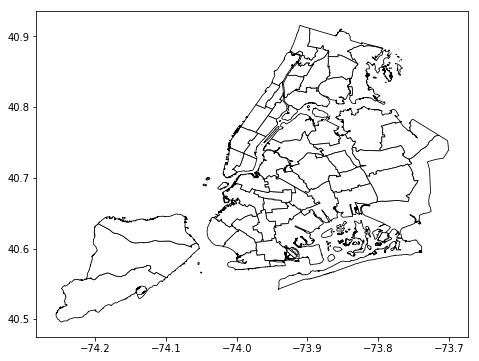

In [6]:
#map for 1.2:

fig, ax = plt.subplots(1, figsize=(10, 6))
puma.plot(column=None, cmap=None, color='white',linewidth=0.8, ax=ax, edgecolor='black')

### Figure 1: Basic Map of New York

In [7]:
#reading in the API data
api_url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', api_url)
survey = json.loads(resp.text)

In [8]:
survey_keys = np.array(list(survey['variables'].keys())) #get variable keys from dictionary

In [47]:
[(k, survey['variables'][k]['label'])  for k in survey_keys if k.startswith ("B28002") and 
 'Broadband' in survey['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [9]:
#number of households
keyNhouseholds = 'B28002_001E'
survey['variables'][keyNhouseholds]

{'label': 'Estimate!!Total',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'predicateType': 'int',
 'group': 'B28002',
 'limit': 0,
 'attributes': 'B28002_001M,B28002_001EA'}

In [10]:
#households with broadband access
keyNBB = 'B28002_004E'
survey['variables'][keyNBB]

{'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'predicateType': 'int',
 'group': 'B28002',
 'limit': 0,
 'attributes': 'B28002_004M,B28002_004EA'}

In [11]:
#accessing the API and extracting the 

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp = requests.request('GET', url).content

puma_broad = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [12]:
puma_broad.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [13]:
#get total households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp1 = requests.request('GET', url).content

puma_all = pd.read_csv(io.StringIO(resp1.decode('utf-8').replace('[','').replace(']','')))

In [14]:
puma_all.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [15]:
puma_broad = puma_broad.merge(puma_all,how='left',left_on='public use microdata area',right_on='public use microdata area')

In [16]:
puma_broad = puma_broad[['B28002_004E','NAME_x','state_x','public use microdata area','B28002_001E']] #select only the columns you need
puma_broad['percentbb'] = puma_broad['B28002_004E'] / puma_broad['B28002_001E']
puma_broad.head()

,B28002_004E,NAME_x,state_x,public use microdata area,B28002_001E,percentbb
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,0.805529
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,0.757333
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,0.798427
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,0.814334
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,0.781507


In [17]:
GCT2801 = pd.read_csv(puidata+'/ACS_16_1YR_GCT2801.ST50_with_ann.csv',usecols=['Target Geo Id2','Percent','Margin of Error'],skiprows=1)

In [18]:
GCT2801.head()

,Target Geo Id2,Percent,Margin of Error
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [19]:
GCT2801.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 3 columns):
Target Geo Id2     2430 non-null int64
Percent            2430 non-null float64
Margin of Error    2430 non-null float64
dtypes: float64(2), int64(1)
memory usage: 57.0 KB


In [20]:
GCT2801['PUMA'] = GCT2801['Target Geo Id2'] - 3600000 #sets puma correctly for areas in NY

In [21]:
GCT2801[GCT2801['PUMA'] > 0]

,Target Geo Id2,Percent,Margin of Error,PUMA
1412,3600100,80.6,2.6,100
1413,3600200,75.7,2.2,200
1414,3600300,79.8,2.6,300
1415,3600401,81.4,2.4,401
1416,3600402,78.2,2.3,402
1417,3600403,76.6,2.2,403
1418,3600500,81.4,2.1,500
1419,3600600,84.4,2.3,600
1420,3600701,67.0,3.0,701
1421,3600702,84.0,2.7,702


In [22]:
puma_broad = puma_broad.merge(GCT2801,how='left',left_on='public use microdata area', right_on='PUMA')

puma_broad.head()

,B28002_004E,NAME_x,state_x,public use microdata area,B28002_001E,percentbb,Target Geo Id2,Percent,Margin of Error,PUMA
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,0.805529,3600100,80.6,2.6,100
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,0.757333,3600200,75.7,2.2,200
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,0.798427,3600300,79.8,2.6,300
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,0.814334,3600401,81.4,2.4,401
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,0.781507,3600402,78.2,2.3,402


In [23]:
puma_broad["diff"] = np.abs(puma_broad["percentbb"] * 100 - puma_broad["Percent"].astype(float))
puma_broad['percentbb'] = puma_broad['percentbb'] * 100
puma_broad['diff'].describe()

count    145.000000
mean       0.026217
std        0.014480
min        0.000178
25%        0.012252
50%        0.027230
75%        0.039090
max        0.049872
Name: diff, dtype: float64

In [24]:
puma_broad.head()
puma_broad_small = puma_broad[['public use microdata area','percentbb']]

In [25]:
puma['puma'] = puma['puma'].astype(float)

In [26]:
puma = puma.merge(puma_broad_small,how='left',left_on='puma',right_on='public use microdata area')

In [27]:
puma.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 6 columns):
puma                         55 non-null float64
shape_area                   55 non-null float64
shape_leng                   55 non-null float64
geometry                     55 non-null object
public use microdata area    55 non-null int64
percentbb                    55 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.0+ KB


Text(0.1, 0.08, 'Fig 2: % of Households with Broadband Access in NYC. Source: American Fact Finder, American Household Survey, 2016')

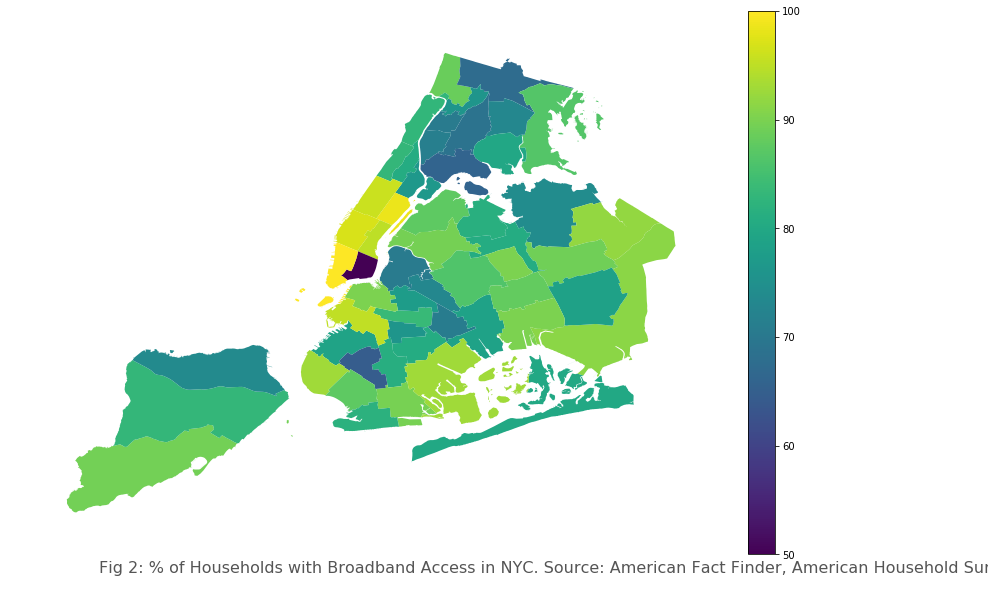

In [28]:
fig, ax = plt.subplots(1, figsize=(15, 10))
puma.plot(column='percentbb', cmap='viridis',linewidth=0.8, ax=ax)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=50, vmax=100))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

ax.annotate('Fig 2: % of Households with Broadband Access in NYC. Source: American Fact Finder, American Household Survey, 2016',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=16, color='#555555')

#fig.savefig(“map_export.png”, dpi=300)

In [29]:
#4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

link_nyc = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv')

In [30]:
link_nyc.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [31]:
link_nyc.shape

(1414, 5)

In [32]:
#convert to geopandas dataframe
geometry = [Point(xy) for xy in zip(link_nyc['longitude'], link_nyc['latitude'])]
crs = {'init': 'epsg:4326'}
link_geo = gpd.GeoDataFrame(link_nyc, crs=crs, geometry=geometry)

In [33]:
puma.head()

,puma,shape_area,shape_leng,geometry,public use microdata area,percentbb
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.275820
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,68.310015
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.826141
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.553737
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,78.778618


In [34]:
link_geo.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,POINT (-73.953439 40.728133)


/nfshome/cb4102/.conda/envs/geoplot/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


Text(0.5, 1.0, '% of Households with Broadbands vs. LinkNYC Stations')

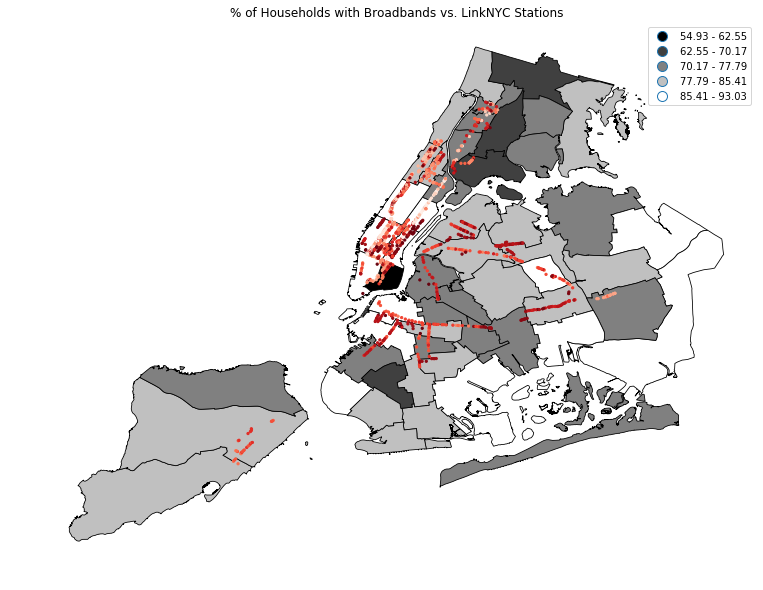

In [35]:
fig, ax = plt.subplots(1, figsize=(15, 10))
puma.plot(column='percentbb', cmap='gist_gray',linewidth=0.8, ax=ax,scheme='Equal_interval', k=5, legend=True,edgecolor='black')
link_geo.plot(column='date_link_',cmap='Reds',ax=ax, markersize=5)
ax.axis('off')
plt.title("% of Households with Broadbands vs. LinkNYC Stations")


#### Figure 2: % of Households with Broadband Access and LinkNYC Stations
##### The figure shows the relationship between broadband access and location of LinkNYC stations. LinkNYC stations are colored based on how long they have existed.

In [36]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + 'B00001_001E' +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36"
resp2 = requests.request('GET', url).content

puma_pop = pd.read_csv(io.StringIO(resp2.decode('utf-8').replace('[','').replace(']','')))

In [78]:
puma_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
B00001_001E                  145 non-null int64
NAME                         145 non-null object
state                        145 non-null int64
public use microdata area    145 non-null int64
Unnamed: 4                   0 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.7+ KB


In [38]:
link_geo.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,POINT (-73.953439 40.728133)


In [39]:
puma.head()

,puma,shape_area,shape_leng,geometry,public use microdata area,percentbb
0,3701.0,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3701,84.275820
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3702,68.310015
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3703,82.826141
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3704,72.553737
4,4015.0,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,78.778618


In [40]:
#convert coordinate systems for 
puma = puma.to_crs(epsg='2263')
link_geo = link_geo.to_crs(epsg='2263')

In [41]:
#join the geodataframes so we know which PUMA each link station is in
links_per_puma = gpd.sjoin(link_geo, puma, how='left', op='intersects')
links_per_puma.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,geometry,index_right,puma,shape_area,shape_leng,public use microdata area,percentbb
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,POINT (1000196.411360609 194918.1045344363),29,4001.0,1.149292e+08,74076.375782,4001,70.631616
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,POINT (1000284.976955119 194872.4991186759),29,4001.0,1.149292e+08,74076.375782,4001,70.631616
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,POINT (1000265.48686938 195013.900946364),29,4001.0,1.149292e+08,74076.375782,4001,70.631616
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,POINT (1000076.658138533 196154.157733508),29,4001.0,1.149292e+08,74076.375782,4001,70.631616
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,POINT (997155.0239397929 204558.4761382252),29,4001.0,1.149292e+08,74076.375782,4001,70.631616


In [42]:
links_per_puma = links_per_puma.groupby('public use microdata area').count()

In [43]:
links_per_puma.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,geometry,index_right,puma,shape_area,shape_leng,percentbb
public use microdata area,,,,,,,,,,,
3701,1,1,1,1,1,1,1,1,1,1,1
3705,1,1,1,1,1,1,1,1,1,1,1
3706,20,20,20,20,20,20,20,20,20,20,20
3707,29,29,29,29,29,29,29,29,29,29,29
3708,19,19,19,19,19,19,19,19,19,19,19


In [44]:
links_per_puma.reset_index(inplace=True)
links_per_puma = links_per_puma[['public use microdata area','link_site','puma']]

In [45]:
links_per_puma.head()

,public use microdata area,link_site,puma
0,3701,1,1
1,3705,1,1
2,3706,20,20
3,3707,29,29
4,3708,19,19


In [47]:
links_per_puma = links_per_puma.merge(puma_pop,how='left',left_on='public use microdata area',right_on='public use microdata area',)

In [48]:
links_per_puma.head()

,public use microdata area,link_site,puma,B00001_001E,NAME,state,Unnamed: 4
0,3701,1,1,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,NaN
1,3705,1,1,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,NaN
2,3706,20,20,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,NaN
3,3707,29,29,1548,NYC-Bronx Community District 5--Morris Heights...,36,NaN
4,3708,19,19,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,NaN


In [68]:
links_per_puma['link_per_pop'] = ( links_per_puma['link_site'] / links_per_puma['B00001_001E'] ) * 100

In [69]:
puma_pp = puma.merge(links_per_puma,how='left',left_on='public use microdata area', right_on='public use microdata area') 

In [72]:
type(puma_pp)

geopandas.geodataframe.GeoDataFrame

In [73]:
puma_pp.head()

,puma_x,shape_area,shape_leng,geometry,public use microdata area,percentbb,link_site,puma_y,B00001_001E,NAME,state,Unnamed: 4,link_per_pop
0,3701.0,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3701,84.275820,1.0,1.0,1517.0,"NYC-Bronx Community District 8--Riverdale, Fie...",36.0,NaN,0.065920
1,3702.0,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3702,68.310015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3703.0,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3703,82.826141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3704.0,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3704,72.553737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4015.0,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",4015,78.778618,3.0,3.0,2515.0,NYC-Brooklyn Community District 14--Flatbush &...,36.0,NaN,0.119284


In [74]:
puma_pp['link_per_pop'].fillna(0,inplace=True)

In [75]:
puma_pp['link_site'].sum() == links_per_puma['link_site'].sum()#check to see all linksites got joined

True

In [76]:
puma_pp.describe()

,puma_x,shape_area,shape_leng,public use microdata area,percentbb,link_site,puma_y,B00001_001E,state,Unnamed: 4,link_per_pop
count,55.000000,5.500000e+01,55.000000,55.000000,55.000000,37.000000,37.000000,37.000000,37.0,0.0,55.000000
mean,3936.218182,1.532632e+08,91547.959548,3936.218182,79.462797,38.216216,38.216216,1938.243243,36.0,NaN,1.565892
std,149.997616,1.361440e+08,77522.481125,149.997616,7.548276,46.499782,46.499782,549.368193,0.0,NaN,2.933074
min,3701.000000,3.984279e+07,34852.437966,3701.000000,54.932945,1.000000,1.000000,1238.000000,36.0,NaN,0.000000
25%,3804.500000,7.498814e+07,48072.809133,3804.500000,74.772059,12.000000,12.000000,1519.000000,36.0,NaN,0.000000
50%,4005.000000,1.070001e+08,70492.955589,4005.000000,79.301693,25.000000,25.000000,1846.000000,36.0,NaN,0.538358
75%,4059.500000,1.692189e+08,98789.538654,4059.500000,85.127599,40.000000,40.000000,2149.000000,36.0,NaN,1.646966
max,4114.000000,6.760200e+08,412606.741739,4114.000000,93.030650,230.000000,230.000000,3940.000000,36.0,NaN,15.141540


Text(0.5, 1.0, 'Link Station Locations and Number of Link Stations per 100 persons')

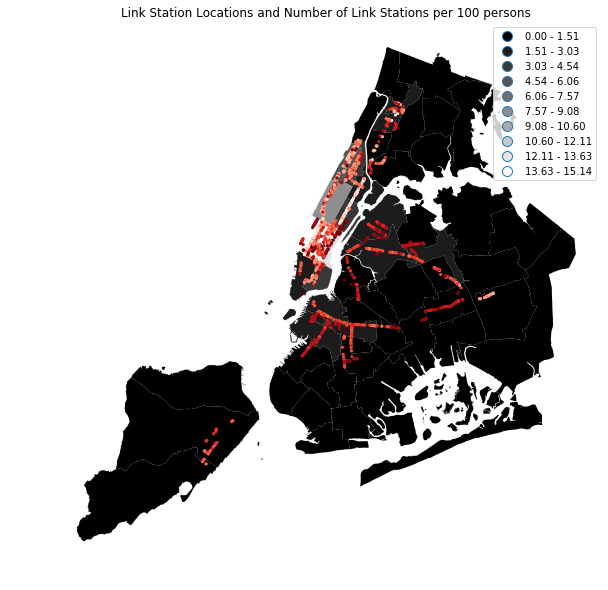

In [77]:
#plot the clorepleth:

fig, ax = plt.subplots(1, figsize=(15, 10))
puma_pp.plot(column='link_per_pop', cmap='gist_gray',linewidth=0.8, ax=ax,scheme='Equal_interval', k=10, legend=True)
link_geo.plot(column='date_link_',cmap='Reds',ax=ax, markersize=5)
ax.axis('off')
plt.title("Link Station Locations and Number of Link Stations per 100 persons")


#### Figure 3: Link Station Locations and number of Link Stations per 100 Persons
##### Figure 3 shows the number of linkNYC stations per 100 residents compared to the specific locations for the linkNYC stations, which are colored based on how long they have existed. LinkNYC stations are concentrated in Manhattan and even with the dense population, Manhattan residents appear to have the highest rates of linkNYC stations per 100 people.

Text(0.5, 1.0, 'Link Station Locations and Number of Link Stations per 100 persons')

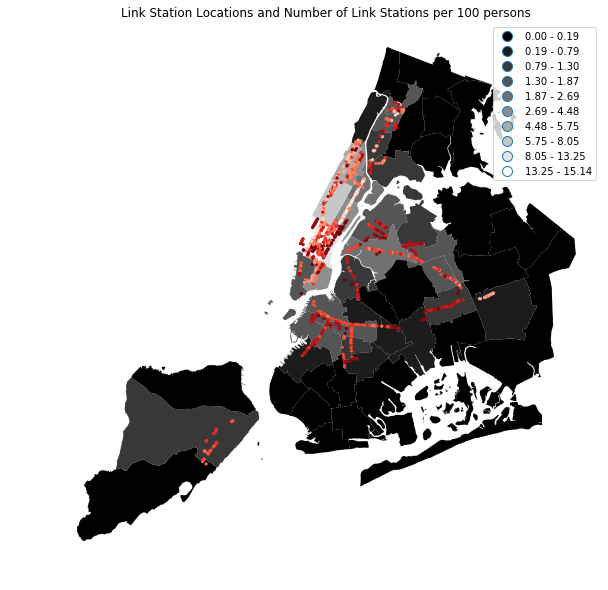

In [80]:
#Extra Credit #1:

#For me the easiest way to make this map more readable is to allow the plotting function to dynamically choose bins. For this 
#we change the scheme criteria to Fischer Jenks. We'll keep the number of bins at 10 so we can see granularity at lower levels.
#Fischer Jenks is an optimization that chooses the bucket ranges the by minimizing the in-class standard deviation and maximizing
#out of class deviation. In other words, it's finding the most distinct clusters and then using these as ranges so we get the most
#variety in our map.


#plot the clorepleth:

fig, ax = plt.subplots(1, figsize=(15, 10))
puma_pp.plot(column='link_per_pop', cmap='gist_gray',linewidth=0.8, ax=ax,scheme='Fisher_Jenks', k=10, legend=True)
link_geo.plot(column='date_link_',cmap='Reds',ax=ax, markersize=5)
ax.axis('off')
plt.title("Link Station Locations and Number of Link Stations per 100 persons")
